# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #4
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, Febrary 23rd, 2018 at 11:00am

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

Name: Christopher Hase

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
import sklearn.metrics
import os

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$
Based on your analysis of the loss function $L$, explain what is happening to your descent algorithms.

In [103]:
# function to compute loss
def loss(x, y, lam1, lam2):
    return 0.000045 * lam2**2 * y - 0.000098 * lam1**2 * x + 0.003926 * lam1 * x * np.exp((-0.1) * (lam1**2 + lam2**2))

# function to compute derivative of loss with respect to lam1
def derivative_loss_lam1(x, y, lam1, lam2):
    return -0.000196 * lam1 * x + x * (0.003926 - 0.007852 * lam1**2 * (x**2 - y**2)) * np.exp((-0.1) * (lam1**2 + lam2**2))

# function to compute derivative of loss with respect to lam2
def derivative_loss_lam2(x, y, lam1, lam2):
    return 0.00009 * lam2 * y - 0.007852 * lam1 * lam2 * x * (0.1) * np.exp((-0.1) * (lam1**2 + lam2**2))

In [104]:
# read in and manipulate data
hw3_data = pd.read_csv('HW3_data.csv', header = None)
hw3_data = hw3_data.transpose()
hw3_data.columns = ['x', 'y']

Gradient Descent

In [113]:
np.random.seed(1)

# initializing lam1 and lam2
lam1s = [-2.47865, -3, -5, -10]
lam2 = 0

lrs = [0.01, 0.001, 0.0001] # learning rate

for i in range(len(lam1s)):
    for lr in lrs:

        loss_current = 0
        
        lam1_current = lam1s[i]
        lam2_current = lam2
        
        # stop updating lambdas when loss 'barely' changes
        while abs(loss_current - np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1_current, lam2_current))) > 0.0000001:
            loss_current = np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1_current, lam2_current))
            num_iter += 1

            lam1_current -= lr * np.sum(derivative_loss_lam1(hw3_data['x'].values, hw3_data['y'].values, lam1_current, lam2_current)) # update lam1
            lam2_current -= lr * np.sum(derivative_loss_lam2(hw3_data['x'].values, hw3_data['y'].values, lam1_current, lam2_current)) # update lam2
        
        print('Lambda 1 (start): ' + str(lam1s[i]))
        print('Lambda 1(end): ' + str(lam1_current))
        print('Lambda 2 (start): ' + str(lam2))
        print('Lambda 2 (end): ' + str(lam2_current))
        print('Learning rate: ' + str(lr))
        print('Net loss: ' + str(np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1_current, lam2_current))))
        print()

Lambda 1 (start): -2.47865
Lambda 1(end): -2.47865012747
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.01
Net loss: 11.9545803086

Lambda 1 (start): -2.47865
Lambda 1(end): -2.47865001275
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.001
Net loss: 11.9545803086

Lambda 1 (start): -2.47865
Lambda 1(end): -2.47865000127
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.0001
Net loss: 11.9545803086

Lambda 1 (start): -3
Lambda 1(end): -5.36146740022
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.01
Net loss: 8.16153144632

Lambda 1 (start): -3
Lambda 1(end): -5.35748731018
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.001
Net loss: 8.16155742623

Lambda 1 (start): -3
Lambda 1(end): -5.34499093332
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.0001
Net loss: 8.16181724474

Lambda 1 (start): -5
Lambda 1(end): -5.361462573
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.01
Net loss: 8.16153146122

Lambda 1 (start): -5
Lambd

Under none of the initial conditions for $\lambda_1$ and $\lambda_2$ is gradient descent converging to the optimal values.

Stochastic gradient descent

In [122]:
np.random.seed(1)

# initializing lam1 and lam2
lam1s = [-2.47865, -3, -5, -10]
lam2 = 0

lrs = [0.01, 0.001, 0.0001] # learning rate

for i in range(len(lam1s)):
    for lr in lrs:
        
        loss_current = 0
        row = 0

        lam1_current = lam1s[i]
        lam2_current = lam2

        # stop updating lambdas when loss 'barely' changes
        while abs(loss_current - np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1_current, lam2_current))) > 0.0000001:
            loss_current = np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1_current, lam2_current))

            lam1_current -= lr * len(hw3_data) * derivative_loss_lam1(hw3_data['x'].values[row], hw3_data['y'].values[row], lam1_current, lam2_current) # update lam1
            lam2_current -= lr * len(hw3_data) * derivative_loss_lam2(hw3_data['x'].values[row], hw3_data['y'].values[row], lam1_current, lam2_current) # update lam2


            row += 1
            if row == len(hw3_data): # condition indicating end of dataset; need to reset
                row = 0

        print('Lambda 1 (start): ' + str(lam1s[i]))
        print('Lambda 1(end): ' + str(lam1_current))
        print('Lambda 2 (start): ' + str(lam2))
        print('Lambda 2 (end): ' + str(lam2_current))
        print('Learning rate: ' + str(lr))
        print('Net loss: ' + str(np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1_current, lam2_current))))
        print()

Lambda 1 (start): -2.47865
Lambda 1(end): -2.4786327669
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.01
Net loss: 11.9545803083

Lambda 1 (start): -2.47865
Lambda 1(end): -2.47864827669
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.001
Net loss: 11.9545803086

Lambda 1 (start): -2.47865
Lambda 1(end): -2.47864982767
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.0001
Net loss: 11.9545803086

Lambda 1 (start): -3
Lambda 1(end): -2.25237788748e+153
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.01
Net loss: nan

Lambda 1 (start): -3
Lambda 1(end): -2.47870502812
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.001
Net loss: 11.9545803027

Lambda 1 (start): -3
Lambda 1(end): -2.47932339477
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.0001
Net loss: 11.9545795291

Lambda 1 (start): -5
Lambda 1(end): -4.65885964931e+153
Lambda 2 (start): 0
Lambda 2 (end): 0.0
Learning rate: 0.01
Net loss: nan

Lambda 1 (start): -5
Lambda 1(end):

Under none of the initial conditions for $\lambda_1$ and $\lambda_2$ is stochastic gradient descent converging to the optimal values.

Analysis of loss function and why descent algos behaving this way...

## Problem 2: Logistic Regression and MNIST (contd)




The MNIST dataset is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves. It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. 

Last time you used PyTorch to build a handwritten digit multi-class logistic regression classifier that you trained and tested with MNIST dataset.

We'll introduce validation sets and regularization in this problem.

Using the softmax formulation, write a PyTorch model that computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimizes the resulting cost function using mini-batch stochastic gradient descent.

Construct and train your classifier using a batch size of 256 examples, a learning rate η=0.1, and a regularization factor λ=0.01.

1. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains. 
2. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for different values of λ? Give an approximate answer supported by using the plots.
3. Select what you consider the best regularization parameter and predict the labels of the test set. Compare with the given labels. What classification accuracy do you obtain on the test set?

In [44]:
# functions/classes taken from: https://gist.github.com/t-vi/9f6118ff84867e89f3348707c7a1271f
# to help create validation set

class PartialDataset(torch.utils.data.Dataset):
    def __init__(self, parent_ds, offset, length):
        self.parent_ds = parent_ds
        self.offset = offset
        self.length = length
        assert len(parent_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(PartialDataset, self).__init__()
    def __len__(self):
        return self.length
    def __getitem__(self, i):
        return self.parent_ds[i+self.offset]

def validation_split(dataset, val_share=0.1):
    """
       Split a (training and vaidation combined) dataset into training and validation.
       Note that to be statistically sound, the items in the dataset should be statistically
       independent (e.g. not sorted by class, not several instances of the same dataset that
       could end up in either set).
    
       inputs:
          dataset:   ("training") dataset to split into training and validation
          val_share: fraction of validation data (should be 0<val_share<1, default: 0.1)
       returns: input dataset split into test_ds, val_ds
       
       """
    val_offset = int(len(dataset)*(1-val_share))
    return PartialDataset(dataset, 0, val_offset), PartialDataset(dataset, val_offset, len(dataset)-val_offset)

In [90]:
torch.manual_seed(1)

# help from: https://gist.github.com/xmfbit/b27cdbff68870418bdb8cefa86a2d558 
# for data loading

# load in MNIST
train_validation = torchvision.datasets.MNIST(root = os.getcwd(), train=True, transform=torchvision.transforms.ToTensor(), download = True)
train, validation = validation_split(train_validation, 1/6) # get train/validation split
test = torchvision.datasets.MNIST(root = os.getcwd(), train=False, transform=torchvision.transforms.ToTensor(), download = True)

# create batches
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

Part 1

In [91]:
# function for computing accuracy
def compute_accuracy(data_loader, model):
    model_pred = []
    targets = []
    for batch in data_loader:
        model_output = model(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # output from linear layer
        model_probs = softmax(model_output).data.numpy() # digit probabilities
        model_pred += np.argmax(model_probs, axis = 1).tolist() # digit predictions
        targets += batch[1].numpy().tolist() # true digit values
        
    return sklearn.metrics.accuracy_score(targets, model_pred)

In [92]:
torch.manual_seed(1)

multiclass_logit = torch.nn.Linear(in_features = 28*28, out_features = 10, bias = True) # linear layer
softmax = torch.nn.Softmax() # softmax to compute output probabilities 
loss_function = torch.nn.CrossEntropyLoss() # cross entropy loss function
optimizer = torch.optim.SGD(multiclass_logit.parameters(), lr = 0.1, weight_decay = 0.01) # SGD optimizer
num_epochs = 25

validation_acc_list = np.zeros(num_epochs)
for epoch in range(num_epochs):

    for batch in train_loader:
        model_output = multiclass_logit(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # model predictions
        targets = Variable(batch[1]) # true digit values
        
        optimizer.zero_grad() # zero gradient
        loss_batch = loss_function(model_output, targets) # compute loss
        loss_batch.backward() # take the gradient wrt parameters
        optimizer.step() # update parameters
                
    validation_acc_list[epoch] = compute_accuracy(validation_loader, multiclass_logit) # compute validation acc and store

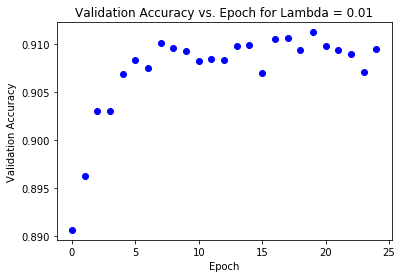

In [93]:
plt.plot(np.arange(num_epochs), validation_acc_list, 'bo')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epoch for Lambda = 0.01')
plt.show()

Part 2

In [70]:
torch.manual_seed(1)

lambdas = [0.1, 0.01, 0.001, 0.0001, 0] # values of lambda to try
softmax = torch.nn.Softmax() # softmax to compute output probabilities 
loss_function = torch.nn.CrossEntropyLoss() # cross entropy loss function
num_epochs = 40

validation_acc_lists = []
for lam in lambdas:

    multiclass_logit = torch.nn.Linear(in_features = 28*28, out_features = 10, bias = True) # linear layer
    optimizer = torch.optim.SGD(multiclass_logit.parameters(), lr = 0.1, weight_decay = lam) # SGD optimizer
    
    validation_acc_list = np.zeros(num_epochs)
    for epoch in range(num_epochs):

        for batch in train_loader:
            model_output = multiclass_logit(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # model predictions
            targets = Variable(batch[1]) # true digit values

            optimizer.zero_grad() # zero gradient
            loss_batch = loss_function(model_output, targets) # compute loss
            loss_batch.backward() # take the gradient wrt parameters
            optimizer.step() # update parameters

        validation_acc_list[epoch] = compute_accuracy(validation_loader, multiclass_logit) # compute validation acc and store
        
    validation_acc_lists.append(validation_acc_list) # add to lists of validation accuracies

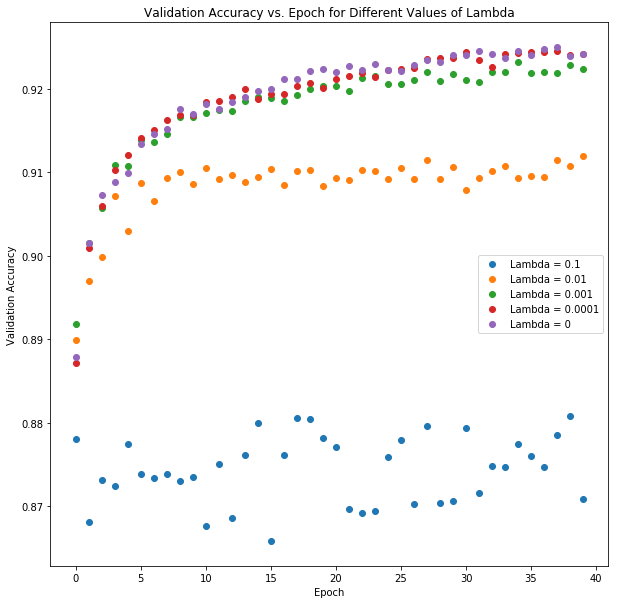

In [72]:
plt.figure(figsize=(10,10))
for i in range(len(lambdas)):
    plt.plot(np.arange(num_epochs), validation_acc_lists[i], 'o')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epoch for Different Values of Lambda')
plt.legend(loc = 'center right', labels = ['Lambda = 0.1', 'Lambda = 0.01',\
                                   'Lambda = 0.001', 'Lambda = 0.0001',\
                                   'Lambda = 0'])
plt.show()

For $\lambda=0.1$, it is sufficient to stop after about 1 epoch. For $\lambda=0.01$, it is sufficient to stop after about 10 epochs. For $\lambda=0.001$, it is sufficient to stop after about 35 epochs. For $\lambda=0.0001$, it is sufficient to stop after about 35 epochs. For $\lambda=0$, it is sufficient to stop after about 35 epochs.

Part 3

$\lambda=0$ appears to be the best regularization parameter, so that the hyperparameter I used when computing test accuracy.

In [76]:
print('Test accuracy when lambda = 0: ' + str(compute_accuracy(test_loader)))

Test accuracy when lambda = 0: 0.9224


## Problem 3: Multi-Layer Perceptron

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is usually chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer with a nonlinearity, then a hidden layer with the nonlinearity, and finally a cross-entropy (or equivalently log-softmax with a log-loss)


Using a similar architecture as in the first part and the same training, validation, and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

1. Use $\lambda = 0.001$ to compare with Problem 2. Experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 20, 50, 100 and 200) and the number of units in your hidden layer (use between 25 and 100 units). For what combination of these parameters do you obtain the highest validation accuracy after a reasonable number of epochs that lead to convergence ( start at 10 epochs and play around a bit for convergence)? How does your test accuracy compare to the logistic regression classifier?
2. Try the same values of $\lambda$ you used in Question 2. Does the test set accuracy improve?


*Hint #1:* The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.

*Hint #2*
Train/Validate/Test split can be done in numpy or in PyTorch. Lab will describe a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`: see the docs.

Part 1

In [94]:
# hyperparameters to try
lam = 0.001
lrs = [0.1, 0.01]
batch_size = [20, 50, 100, 200]
hidden_units = [50, 75, 100]
num_epochs = 35

softmax = torch.nn.Softmax() # softmax to compute output probabilities 
loss_function = torch.nn.CrossEntropyLoss() # cross entropy loss function

In [95]:
torch.manual_seed(1)

for lr in lrs:
    for size in batch_size:
        for hidden in hidden_units:
            
            # create train batches
            train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = size, shuffle = True)
                
            # model architecture
            multi_perceptron = torch.nn.Linear(in_features = 28*28, out_features = hidden, bias = True) # linear layer
            multi_perceptron.add_module(name = 'tanh', module = torch.nn.Tanh()) # tanh function for hidden layer
            multi_perceptron.add_module(name = '2nd linear', module = torch.nn.Linear(in_features = hidden, out_features = 10, bias = True)) # 2nd linear layer
            optimizer = torch.optim.SGD(multi_perceptron.parameters(), lr = lr, weight_decay = lam) # SGD optimizer
                
            for epoch in range(num_epochs):   
                for batch in train_loader:
                    model_output = multi_perceptron(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # model predictions
                    targets = Variable(batch[1]) # true digit values

                    optimizer.zero_grad() # zero gradient
                    loss_batch = loss_function(model_output, targets) # compute loss
                    loss_batch.backward() # take the gradient wrt parameters
                    optimizer.step() # update parameters
                    
            print('Validation accuracy for lambda=' + str(lam) + ', learning rate=' + str(lr) + ', batch size='\
                  + str(size) + ', hidden units=' + str(hidden) + ': ' + str(compute_accuracy(validation_loader, multi_perceptron))) # compute validation acc

Validation accuracy for lambda=0.001, learning rate=0.1, batch size=20, hidden units=50: 0.9188
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=20, hidden units=75: 0.921
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=20, hidden units=100: 0.9196
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=50, hidden units=50: 0.923
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=50, hidden units=75: 0.9239
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=50, hidden units=100: 0.9223
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=100, hidden units=50: 0.9229
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=100, hidden units=75: 0.9235
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=100, hidden units=100: 0.9239
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=200, hidden units=50: 0.9226
Validation accuracy for lambda=0.00

I obtained the highest validation accuracy (0.9239) with $\lambda=0.001$, learning rate of 0.1, batch size of 100, and 100 hidden units.

In [96]:
torch.manual_seed(1)

# best hyperparams
lam = 0.001
lr = 0.1
size = 100
hidden = 100

# create train batches
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = size, shuffle = True)

# model architecture
multi_perceptron = torch.nn.Linear(in_features = 28*28, out_features = hidden, bias = True) # linear layer
multi_perceptron.add_module(name = 'tanh', module = torch.nn.Tanh()) # tanh function for hidden layer
multi_perceptron.add_module(name = '2nd linear', module = torch.nn.Linear(in_features = hidden, out_features = 10, bias = True)) # 2nd linear layer
optimizer = torch.optim.SGD(multi_perceptron.parameters(), lr = lr, weight_decay = lam) # SGD optimizer
                
for epoch in range(num_epochs):   
    for batch in train_loader:
        model_output = multi_perceptron(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # model predictions
        targets = Variable(batch[1]) # true digit values

        optimizer.zero_grad() # zero gradient
        loss_batch = loss_function(model_output, targets) # compute loss
        loss_batch.backward() # take the gradient wrt parameters
        optimizer.step() # update parameters
                    
print('Test accuracy for lambda=' + str(lam) + ', learning rate=' + str(lr) + ', batch size='\
        + str(size) + ', hidden units=' + str(hidden) + ': ' + str(compute_accuracy(test_loader, multi_perceptron))) # compute validation acc

Test accuracy for lambda=0.001, learning rate=0.1, batch size=100, hidden units=100: 0.9217


The test accuracy we see here is slightly lower than the test set accuracy from problem 2 when using $\lambda=0$. 

Part 2

Using the best learning rate, number of hidden units, batch size combination from part 1 of problem 3, I computed the validation accuracies when using the values of $\lambda$ from part 2 of problem 2. For the combination with the highest validation accuracy, I computed the test accuracy.

In [99]:
torch.manual_seed(1)

# best hyperparams from part 1 of problem 3
lr = 0.1
size = 100
hidden = 100

softmax = torch.nn.Softmax() # softmax to compute output probabilities 
loss_function = torch.nn.CrossEntropyLoss() # cross entropy loss function
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = size, shuffle = True) # create train batches

num_epochs = 35
lambdas = [0.1, 0.01, 0.001, 0.0001, 0] # values of lambda to try
for lam in lambdas:
    
    # model architecture
    multi_perceptron = torch.nn.Linear(in_features = 28*28, out_features = hidden, bias = True) # linear layer
    multi_perceptron.add_module(name = 'tanh', module = torch.nn.Tanh()) # tanh function for hidden layer
    multi_perceptron.add_module(name = '2nd linear', module = torch.nn.Linear(in_features = hidden, out_features = 10, bias = True)) # 2nd linear layer
    optimizer = torch.optim.SGD(multi_perceptron.parameters(), lr = lr, weight_decay = lam) # SGD optimizer
    
    for epoch in range(num_epochs):

        for batch in train_loader:
            model_output = multi_perceptron(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # model predictions
            targets = Variable(batch[1]) # true digit values

            optimizer.zero_grad() # zero gradient
            loss_batch = loss_function(model_output, targets) # compute loss
            loss_batch.backward() # take the gradient wrt parameters
            optimizer.step() # update parameters

    print('Validation accuracy for lambda=' + str(lam) + ', learning rate=' + str(lr) + ', batch size='\
          + str(size) + ', hidden units=' + str(hidden) + ': ' + str(compute_accuracy(validation_loader, multi_perceptron))) # compute validation acc

Validation accuracy for lambda=0.1, learning rate=0.1, batch size=100, hidden units=100: 0.8715
Validation accuracy for lambda=0.01, learning rate=0.1, batch size=100, hidden units=100: 0.9058
Validation accuracy for lambda=0.001, learning rate=0.1, batch size=100, hidden units=100: 0.9235
Validation accuracy for lambda=0.0001, learning rate=0.1, batch size=100, hidden units=100: 0.9274
Validation accuracy for lambda=0, learning rate=0.1, batch size=100, hidden units=100: 0.9284


I obtained the highest validation accuracy (0.9284) when $\lambda=0$.

In [100]:
print('Test accuracy for lambda=' + str(lam) + ', learning rate=' + str(lr) + ', batch size='\
      + str(size) + ', hidden units=' + str(hidden) + ': ' + str(compute_accuracy(test_loader, multi_perceptron))) # compute validation acc

Test accuracy for lambda=0, learning rate=0.1, batch size=100, hidden units=100: 0.9233


The test set accuracy (0.9233) improved when I set $\lambda=0$ and is slightly higher than the test accuracy obtained in problem 2 (0.9224).